# Analysis of Customer Data Project Group 19
#### Fedor Markizov
#### Jesse Osseweijer
#### Puck Bongenaar
#### Noah Bouwhuis

# Exploratory Data Analysis and Data Preparation

### Descriptive Statistics

In [1]:
#start
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
data = pd.read_csv('Assignment_data.csv')

# Number of rows and columns
print("\nNumber of rows and columns:")
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")

# Column names
print("\nColumn names:")
print(data.columns.tolist())

# Data types of each column
print("\nData types of each column:")
print(data.dtypes)

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Basic statistics summary for numerical columns
print("\nSummary statistics for numerical columns:")
print(data.describe())

# Basic statistics summary for categorical columns
print("\nSummary statistics for categorical columns:")
print(data.describe(include='object'))


Number of rows and columns:
Rows: 153929, Columns: 3

Column names:
['device', 'score', 'time']

Data types of each column:
device    object
score      int64
time       int64
dtype: object

Missing values in each column:
device    9
score     0
time      0
dtype: int64

Summary statistics for numerical columns:
               score          time
count  153929.000000  1.539290e+05
mean      195.932625  1.437807e+09
std       443.613021  1.206984e+07
min         0.000000  1.421157e+09
25%        20.000000  1.427000e+09
50%        72.000000  1.435468e+09
75%       205.000000  1.448691e+09
max     20964.000000  1.464092e+09

Summary statistics for categorical columns:
                 device
count            153920
unique            25956
top     012345678912345
freq               1618


## Creating Churn Status

#### A churn variable is creates with an observation period (OP) of 14 days and a churn period (CP) of 90 days. Some descriptive information is provided. 

In [2]:
import pandas as pd
import numpy as np

# Step 1: Convert 'time' from Unix timestamp to datetime format
data['time'] = pd.to_datetime(data['time'], unit='s')

# Step 2: Find each player's 't0' (first recorded play session)
player_t0 = data.groupby('device')['time'].min().reset_index()
player_t0.columns = ['device', 't0']
data = data.merge(player_t0, on='device', how='left')

# Define OP and CP lengths (in days)
OP_length_days = 14  # Observation Period length
CP_length_days = 90  # Churn Prediction Period length

# Step 3: Define OP and CP end times based on 't0'
data['OP_end'] = data['t0'] + pd.to_timedelta(OP_length_days, unit='D')
data['CP_end'] = data['OP_end'] + pd.to_timedelta(CP_length_days, unit='D')

# Step 4: Determine if each play session is in OP, CP, or After_CP
data['period'] = data.apply(
    lambda row: 'OP' if row['time'] <= row['OP_end']
    else ('CP' if row['time'] <= row['CP_end'] else 'After_CP'), axis=1
)

# Step 5: Count play sessions in each period for each player
play_counts = data.groupby(['device', 'period']).size().unstack(fill_value=0)

# Ensure that both 'OP' and 'CP' columns exist, filling with 0 if missing
if 'OP' not in play_counts.columns:
    play_counts['OP'] = 0
if 'CP' not in play_counts.columns:
    play_counts['CP'] = 0

# Step 6: Create churn status
# Churn = 1 if the player has activity in OP but none in CP, otherwise Churn = 0
play_counts['churn'] = play_counts.apply(lambda row: 0 if row['OP'] > 0 and row['CP'] > 0 else 1, axis=1)

# Analyze churn distribution
churn_distribution = play_counts['churn'].value_counts(normalize=True)
print(" ⁠is someone churn or not")
print()
# Display churn distribution and sample data with churn labels
print("Churn Distribution (0 = No churn, 1 = Churn):")
print(churn_distribution)

print("\nSample of play_counts with churn labels:")
print(play_counts.head())
print()
print()

 ⁠is someone churn or not

Churn Distribution (0 = No churn, 1 = Churn):
churn
1    0.923794
0    0.076206
Name: proportion, dtype: float64

Sample of play_counts with churn labels:
period           After_CP   CP  OP  churn
device                                   
0                       1    0   3      1
000000000000000        36    1   3      0
010941525590041         0    0   1      1
012345678901237         0    0   2      1
012345678912345      1202  411   5      0




### Visualizing the correlation between first-time Score and Churn Status

Correlation between first-time score and churn status: -0.012175403542194416


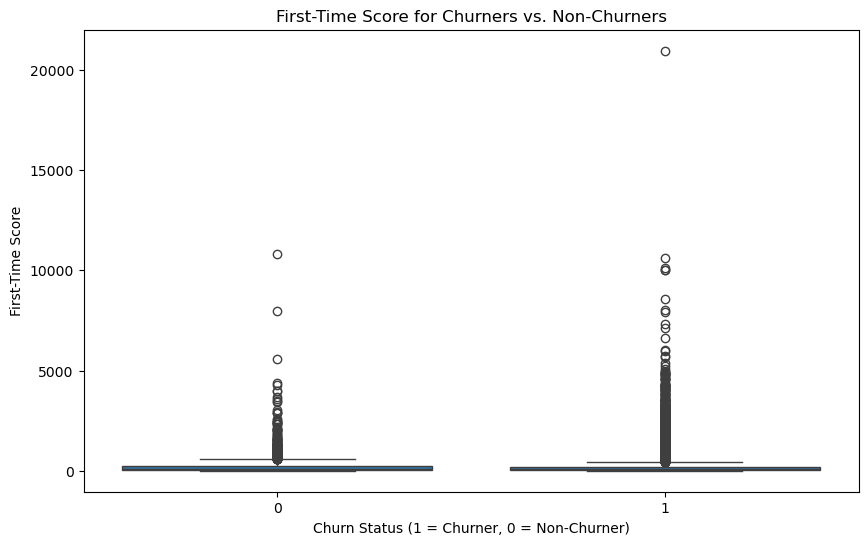

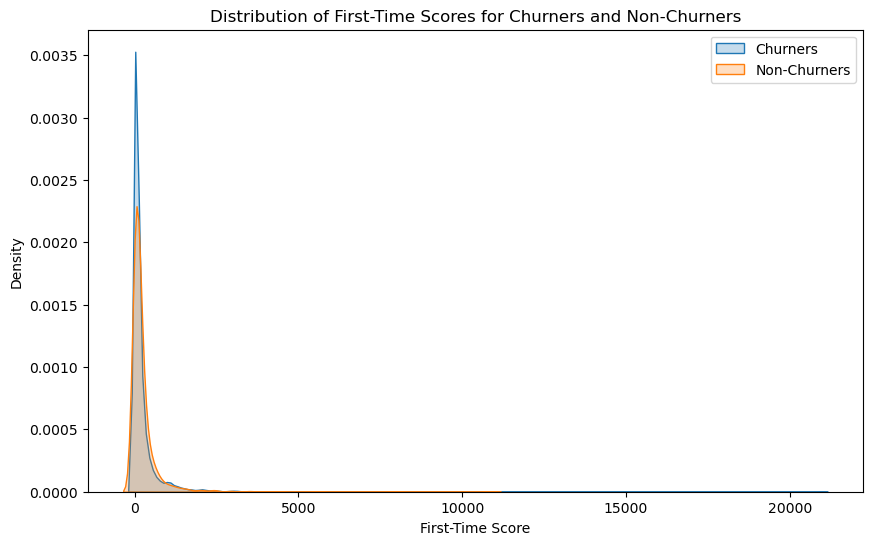

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

data['time'] = pd.to_datetime(data['time'], unit='s')

# Sort data by device and time to identify the first score for each player
data = data.sort_values(by=['device', 'time'])

# Extract the first score for each player
first_scores = data.groupby('device').first().reset_index()[['device', 'score']]
first_scores.columns = ['device', 'first_score']

# Merge with churn data (assuming play_counts with churn status from previous analysis is available)
play_counts = play_counts.reset_index()  # Ensure play_counts has 'device' as a column
first_scores = first_scores.merge(play_counts[['device', 'churn']], on='device', how='left')

# Calculate correlation between first-time score and churn
correlation_first_score_churn = first_scores['first_score'].corr(first_scores['churn'])
print(f"Correlation between first-time score and churn status: {correlation_first_score_churn}")

# Visualize the first-time scores for churners and non-churners using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=first_scores, x='churn', y='first_score')
plt.title('First-Time Score for Churners vs. Non-Churners')
plt.xlabel('Churn Status (1 = Churner, 0 = Non-Churner)')
plt.ylabel('First-Time Score')
plt.show()

# Optional: Visualize distribution with a KDE plot for each group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=first_scores[first_scores['churn'] == 1], x='first_score', label='Churners', fill=True)
sns.kdeplot(data=first_scores[first_scores['churn'] == 0], x='first_score', label='Non-Churners', fill=True)
plt.title('Distribution of First-Time Scores for Churners and Non-Churners')
plt.xlabel('First-Time Score')
plt.ylabel('Density')
plt.legend()
plt.show()

### Correlation between score and time played

Correlation between score and session duration: 0.024957060509048182


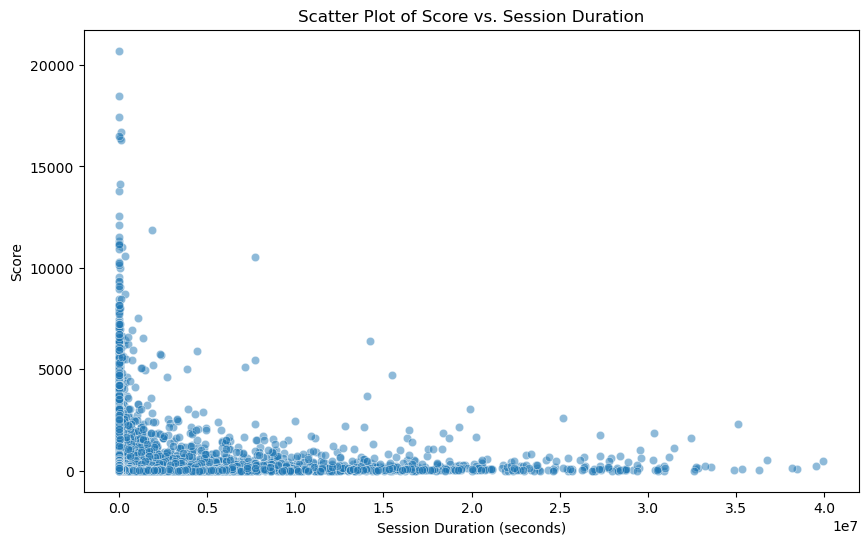

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


data['time'] = pd.to_datetime(data['time'], unit='s')

# Sort data by device and time for accurate session duration calculation
data = data.sort_values(by=['device', 'time'])

# Calculate session duration (difference in time between consecutive sessions)
# For each player, calculate the time difference with the next session
data['session_duration'] = data.groupby('device')['time'].diff().dt.total_seconds()

# Drop rows with NaN in session_duration (first session for each player has no prior session to calculate duration)
data = data.dropna(subset=['session_duration'])

# Calculate the correlation between score and session duration
correlation = data['score'].corr(data['session_duration'])
print(f"Correlation between score and session duration: {correlation}")

# Visualize the relationship with a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='session_duration', y='score', alpha=0.5)
plt.title('Scatter Plot of Score vs. Session Duration')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Score')
plt.show()

### Average score over time

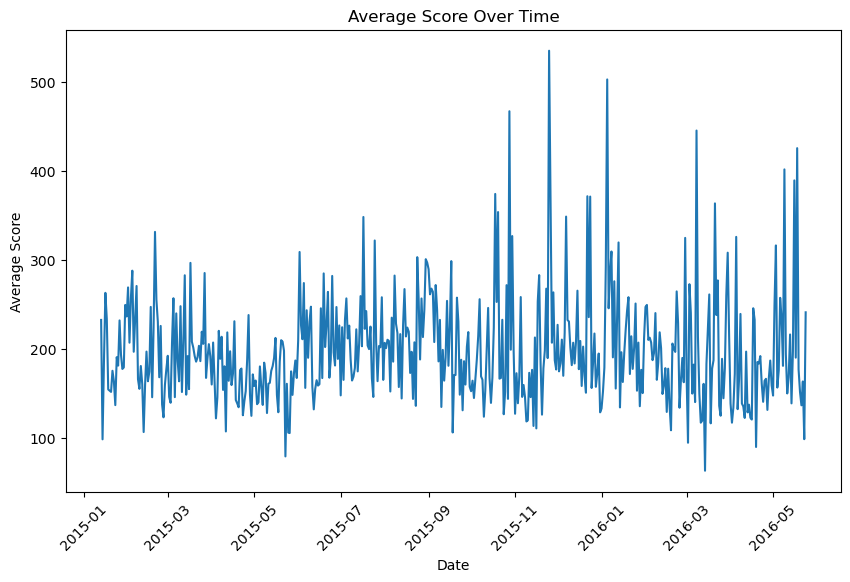

In [5]:
data['date'] = data['time'].dt.date  # Extract date only for daily aggregation
daily_avg_score = data.groupby('date')['score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(daily_avg_score['date'], daily_avg_score['score'])
plt.title('Average Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

### Average score per session

In [6]:
player_scores = data.groupby('device').agg(
    total_score=('score', 'sum'),      # Total score for each player
    session_count=('time', 'nunique')  # Count of unique sessions for each player
).reset_index()

# Calculate average score per session
player_scores['average_score_per_session'] = player_scores['total_score'] / player_scores['session_count']

# Display the first few rows of the results
print(player_scores[['device', 'total_score', 'session_count', 'average_score_per_session']].head())

            device  total_score  session_count  average_score_per_session
0                0          366              3                 122.000000
1  000000000000000        12143             39                 311.358974
2  012345678901237           32              1                  32.000000
3  012345678912345      1171128           1617                 724.259740
4  012403004537025           41              3                  13.666667


In [7]:
# data['time'] = pd.to_datetime(data['time'], unit='s')

# # Sort data by device and time to identify the first score for each player
# data = data.sort_values(by=['device', 'time'])

# # Extract the first score for each player
# first_scores = data.groupby('device').first().reset_index()[['device', 'score']]
# first_scores.columns = ['device', 'first_score']

# # Merge with churn data (assuming play_counts with churn status from previous analysis is available)
# # play_counts = play_counts.reset_index()  # Ensure play_counts has 'device' as a column
# # first_scores = first_scores.merge(play_counts[['device', 'churn']], on='device', how='left')

# # Calculate correlation between first-time score and churn
# correlation_first_score_churn = first_scores['first_score'].corr(first_scores['churn'])
# print(f"Correlation between first-time score and churn status: {correlation_first_score_churn}")

# # Visualize the first-time scores for churners and non-churners using a box plot
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=first_scores, x='churn', y='first_score')
# plt.title('First-Time Score for Churners vs. Non-Churners')
# plt.xlabel('Churn Status (1 = Churner, 0 = Non-Churner)')
# plt.ylabel('First-Time Score')
# plt.show()

# # Optional: Visualize distribution with a KDE plot for each group
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=first_scores[first_scores['churn'] == 1], x='first_score', label='Churners', fill=True)
# sns.kdeplot(data=first_scores[first_scores['churn'] == 0], x='first_score', label='Non-Churners', fill=True)
# plt.title('Distribution of First-Time Scores for Churners and Non-Churners')
# plt.xlabel('First-Time Score')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

### SEASONS AND TIMES PLAYED

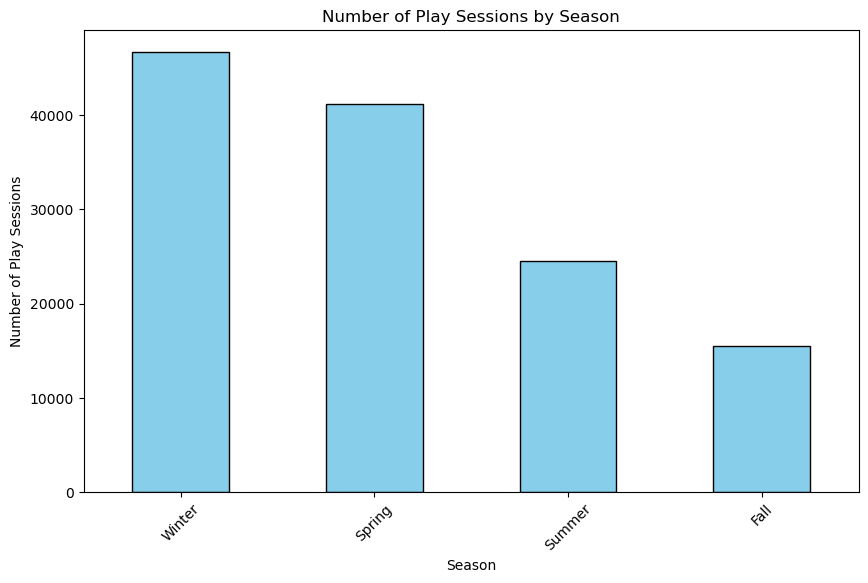

In [8]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to create a 'season' column
data['season'] = data['time'].dt.month.apply(get_season)

# Count the number of sessions by season
season_counts = data['season'].value_counts().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Plot the results
plt.figure(figsize=(10, 6))
season_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Play Sessions by Season')
plt.xlabel('Season')
plt.ylabel('Number of Play Sessions')
plt.xticks(rotation=45)
plt.show()

### Calculating Mahalanobis Distance and Identifying Outliers

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

# Mahalanobis Distance Calculation Function
def mahalanobis_distance(df, columns):
    cov_matrix = np.cov(df[columns].values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_diffs = df[columns] - df[columns].mean()
    left_term = np.dot(mean_diffs, inv_cov_matrix)
    mahalanobis_dists = np.sqrt(np.sum(left_term * mean_diffs, axis=1))
    return mahalanobis_dists

# Drop NaN values to ensure clean calculation
data = data.dropna(subset=['session_duration', 'score'])

# Calculate Mahalanobis distance for 'session_duration' and 'score'
data['mahalanobis_dist'] = mahalanobis_distance(data, ['session_duration', 'score'])

# Set a threshold for outliers based on the chi-square distribution
threshold = chi2.ppf(0.95, df=2)  # 95% confidence interval, 2 degrees of freedom
data['outlier'] = data['mahalanobis_dist'] > np.sqrt(threshold)

# Count outliers and non-outliers
outlier_counts = data['outlier'].value_counts()
print("\nOutlier Counts:")
print(outlier_counts)



Outlier Counts:
outlier
False    123938
True       4026
Name: count, dtype: int64


### Outliers Visualisation

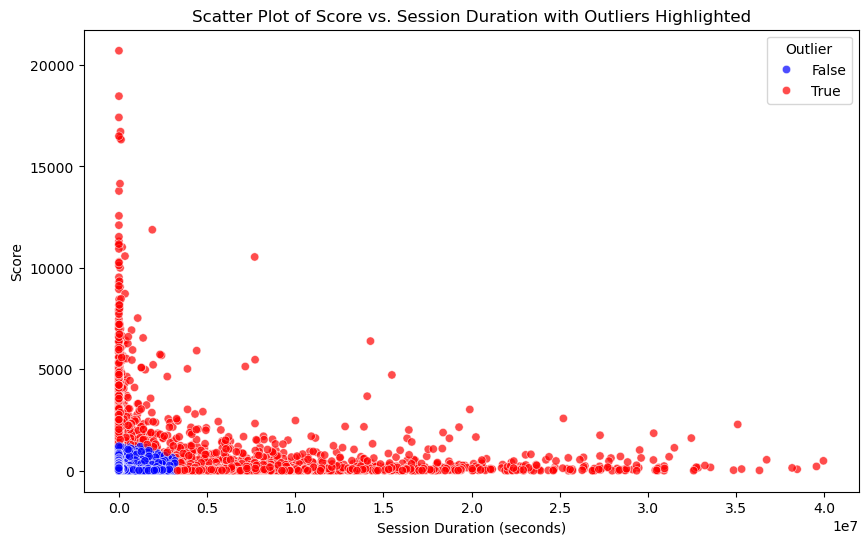

In [10]:
# Scatter plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='session_duration', y='score', hue='outlier', 
                palette={False: 'blue', True: 'red'}, alpha=0.7)
plt.title('Scatter Plot of Score vs. Session Duration with Outliers Highlighted')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Score')
plt.legend(title='Outlier', loc='upper right')
plt.show()


### Code Explanation
This code snippet is responsible for:
- **Preview:** `from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression`
- **Details:** Add specific details about what this code achieves.


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("Assignment_data.csv")

# Convert Unix Epoch Time to standard datetime
data['time'] = pd.to_datetime(data['time'], unit='s')

# Sort data by device and time
data = data.sort_values(by=['device', 'time'])

# Create a session identifier by grouping consecutive gameplays
data['session_id'] = (data['device'] != data['device'].shift()) | (data['time'].diff() > pd.Timedelta(hours=1))
data['session_id'] = data['session_id'].cumsum()

# Calculate Average Score per Session
session_scores = data.groupby(['device', 'session_id'])['score'].sum().reset_index()
avg_score_per_session = session_scores.groupby('device')['score'].mean().rename('avg_score_per_session')

# Calculate Total Sessions per Player
total_sessions = session_scores.groupby('device').size().rename('total_sessions')

# Calculate Session Frequency (average time between sessions)
session_times = data.groupby(['device', 'session_id'])['time'].max().reset_index()
session_times['time_diff'] = session_times.groupby('device')['time'].diff().dt.total_seconds()
session_frequency = session_times.groupby('device')['time_diff'].mean().rename('session_frequency')

# Calculate Max Score in a Session
max_score_per_session = session_scores.groupby('device')['score'].max().rename('max_score_per_session')

# Calculate Recency of Last Session
last_session_time = session_times.groupby('device')['time'].max()
data_end_time = data['time'].max()
recency_of_last_session = (data_end_time - last_session_time).dt.days.rename('recency_of_last_session')

# Combine all new features into a single dataframe
new_features = pd.concat([
    avg_score_per_session,
    total_sessions,
    session_frequency,
    max_score_per_session,
    recency_of_last_session
], axis=1).reset_index()

# Merge new features back into the original data
data = data.merge(new_features, on='device', how='left')

# Drop intermediate columns that are no longer needed
data = data.drop(columns=['session_id'], errors='ignore')

# Create the churn feature
churn_period = pd.Timedelta(days=14)
data['last_activity'] = data.groupby('device')['time'].transform('max')
data['churn'] = (data['last_activity'] + churn_period < data['time'].max()).astype(int)


### Code Explanation
This code snippet is responsible for:
- **Preview:** `data`
- **Details:** Add specific details about what this code achieves.


In [12]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn
0,0,45,2015-04-11 11:52:38,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
1,0,115,2015-04-11 11:53:33,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
2,0,14,2015-04-11 11:54:32,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
3,0,237,2016-02-11 07:56:21,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
4,000000000000000,1,2015-01-23 02:04:44,1518.0,8.0,4.558758e+06,5847.0,118.0,2016-01-27 10:20:57,1
...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,NaN,NaN,NaN,NaN,NaN,NaT,0
153925,NaN,374,2015-01-21 14:15:37,NaN,NaN,NaN,NaN,NaN,NaT,0
153926,NaN,35,2015-01-21 14:16:05,NaN,NaN,NaN,NaN,NaN,NaT,0
153927,NaN,112,2015-01-21 14:16:52,NaN,NaN,NaN,NaN,NaN,NaT,0


### Code Explanation
This code snippet is responsible for:
- **Preview:** `# Calculate additional features
# 1. Total Score per Player
data['total_score'] = data.groupby('device')['score'].transform('sum')`
- **Details:** Add specific details about what this code achieves.


In [13]:
# Calculate additional features
# 1. Total Score per Player
data['total_score'] = data.groupby('device')['score'].transform('sum')

# 2. Average Score per Session
data['avg_score'] = data.groupby('device')['score'].transform('mean')

# 3. Max Score in a Single Session
data['max_score'] = data.groupby('device')['score'].transform('max')

# 4. Standard Deviation of Scores
data['std_score'] = data.groupby('device')['score'].transform('std').fillna(0)  # Replace NaN with 0 for single-session players

# 5. Days Since First Activity
data['days_since_first'] = (data['time'] - data.groupby('device')['time'].transform('min')).dt.days

# 6. Days Between Sessions
data['days_between_sessions'] = data.groupby('device')['time'].diff().dt.days.fillna(0)  # Fill NaN for first session

# 7. Session Count
data['session_count'] = data.groupby('device')['time'].transform('count')

# 8. Score Density (Score per Day)
data['score_density'] = data['total_score'] / (data['days_since_first'] + 1)  # Avoid division by zero

# 9. Last Session Score Ratio
data['last_session_score'] = data.groupby('device')['score'].transform('last')
data['last_score_ratio'] = data['last_session_score'] / (data['avg_score'] + 1)  # Avoid division by zero

# 10. Activity Intensity (Sessions per Day)
data['activity_intensity'] = data['session_count'] / (data['days_since_first'] + 1)  # Avoid division by zero

data['combined_score'] = data['total_score'] / data['session_count']


### Code Explanation
This code snippet is responsible for:
- **Preview:** `data`
- **Details:** Keeping track of variables


In [14]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn,...,max_score,std_score,days_since_first,days_between_sessions,session_count,score_density,last_session_score,last_score_ratio,activity_intensity,combined_score
0,0,45,2015-04-11 11:52:38,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
1,0,115,2015-04-11 11:53:33,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
2,0,14,2015-04-11 11:54:32,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
3,0,237,2016-02-11 07:56:21,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,305.0,305.0,4.0,1.343137,237.0,2.284337,0.013072,102.75
4,000000000000000,1,2015-01-23 02:04:44,1518.0,8.0,4.558758e+06,5847.0,118.0,2016-01-27 10:20:57,1,...,2317.0,398.282132,0.0,0.0,40.0,12144.000000,115.0,0.377544,40.000000,303.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153925,NaN,374,2015-01-21 14:15:37,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153926,NaN,35,2015-01-21 14:16:05,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153927,NaN,112,2015-01-21 14:16:52,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Handling missing data

### Code Explanation
This code snippet is responsible for:
- **Preview:** `# Define columns to check for missing values
columns_to_impute = [`
- **Details:** Detect missing values and use SimpleImputer to impute the mean


In [15]:

# Define columns to check for missing values
columns_to_impute = [
    'avg_score_per_session', 'total_sessions', 'session_frequency',
    'max_score_per_session', 'recency_of_last_session',
    'total_score', 'avg_score', 'max_score', 'std_score',
    'days_since_first', 'days_between_sessions', 'session_count',
    'score_density', 'last_score_ratio', 'activity_intensity', 'last_session_score',
    'combined_score'
]

# Filter out non-numeric columns
columns_to_impute = [col for col in columns_to_impute if pd.api.types.is_numeric_dtype(data[col])]

# Check missing values before imputation
print("Missing values before imputation:")
print(data[columns_to_impute].isnull().sum())

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

# Check missing values after imputation
print("\nMissing values after imputation:")
print(data[columns_to_impute].isnull().sum())


Missing values before imputation:
avg_score_per_session          9
total_sessions                 9
session_frequency          39425
max_score_per_session          9
recency_of_last_session        9
total_score                    9
avg_score                      9
max_score                      9
std_score                      0
days_since_first               9
days_between_sessions          0
session_count                  9
score_density                  9
last_score_ratio               9
activity_intensity             9
last_session_score             9
combined_score                 9
dtype: int64

Missing values after imputation:
avg_score_per_session      0
total_sessions             0
session_frequency          0
max_score_per_session      0
recency_of_last_session    0
total_score                0
avg_score                  0
max_score                  0
std_score                  0
days_since_first           0
days_between_sessions      0
session_count              0
score_dens

### Code Explanation
This code snippet is responsible for:
- **Preview:** `data`
- **Details:** Keeping track of the data


In [16]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn,...,max_score,std_score,days_since_first,days_between_sessions,session_count,score_density,last_session_score,last_score_ratio,activity_intensity,combined_score
0,0,45,2015-04-11 11:52:38,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
1,0,115,2015-04-11 11:53:33,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
2,0,14,2015-04-11 11:54:32,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
3,0,237,2016-02-11 07:56:21,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,305.000000,305.0,4.000000,1.343137,237.000000,2.284337,0.013072,102.750000
4,000000000000000,1,2015-01-23 02:04:44,1518.000000,8.000000,4.558758e+06,5847.000000,118.000000,2016-01-27 10:20:57,1,...,2317.000000,398.282132,0.000000,0.0,40.000000,12144.000000,115.000000,0.377544,40.000000,303.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153925,NaN,374,2015-01-21 14:15:37,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153926,NaN,35,2015-01-21 14:16:05,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153927,NaN,112,2015-01-21 14:16:52,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034


### Code Explanation
This code snippet is responsible for:
- **Preview:** `# Check data types of each column
print(data.dtypes)`
- **Details:** Inspecting data types in preparation for analysis



In [17]:
# Check data types of each column
print(data.dtypes)

# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


device                             object
score                               int64
time                       datetime64[ns]
avg_score_per_session             float64
total_sessions                    float64
session_frequency                 float64
max_score_per_session             float64
recency_of_last_session           float64
last_activity              datetime64[ns]
churn                               int32
total_score                       float64
avg_score                         float64
max_score                         float64
std_score                         float64
days_since_first                  float64
days_between_sessions             float64
session_count                     float64
score_density                     float64
last_session_score                float64
last_score_ratio                  float64
activity_intensity                float64
combined_score                    float64
dtype: object
Non-numeric columns: Index(['device'], dtype='object')


### Checking for multicolinearity

### Code Explanation
This code snippet is responsible for:
- **Preview:** `import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant`
- **Details:** Compute VIF score to control for multicolinearity in preparation for the analysis


In [19]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Drop non-numeric columns explicitly
X = data.drop(['time', 'device', 'last_activity'], axis=1)

# Convert columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')


X = sm.add_constant(X)


vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


c:\Anaconda3-2024.06\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    Feature        VIF
0                     const  42.098871
1                     score   1.913094
2     avg_score_per_session   4.033927
3            total_sessions  15.016838
4         session_frequency   1.238832
5     max_score_per_session   5.791533
6   recency_of_last_session   1.241090
7                     churn   1.118251
8               total_score  15.201552
9                 avg_score        inf
10                max_score  16.061208
11                std_score   5.084159
12         days_since_first   1.523972
13    days_between_sessions   1.200388
14            session_count  20.923418
15            score_density   2.702142
16       last_session_score   3.134806
17         last_score_ratio   1.612269
18       activity_intensity   2.913435
19           combined_score        inf


### Train/test split

### Code Explanation
This code snippet is responsible for:
- **Details:** Defining the dependent and independent variables and performing train/test split. Only selected our created variables that passed the multicolinearity test. Dropped other variables minimalize noise.


In [38]:

# Prepare features and target variable
# features = ['avg_score_per_session', 'total_sessions', 'session_frequency', 
#             'max_score_per_session', 'recency_of_last_session']
# features = data.drop(columns=['churn', 'recency_of_last_session', 'device', 'last_activity',
#                               'time'])
features = [
    'score',
    'session_frequency',
    'days_since_first',
    'days_between_sessions',
    'activity_intensity',
    'total_sessions',
    'score_density',
    'std_score',
    
    'avg_score_per_session',
    'last_session_score',
    'last_score_ratio'
]

X = data[features]

y = data['churn']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Code Explanation
This code snippet is responsible for:
- **Preview:** `X`
- **Details:** final overview of X before performing SMOTE


In [39]:
X

,score,session_frequency,days_since_first,days_between_sessions,activity_intensity,total_sessions,score_density,std_score,avg_score_per_session,last_session_score,last_score_ratio
0,45,2.642411e+07,0.000000,0.0,4.000000,2.000000,411.000000,98.969271,205.500000,237.000000,2.284337
1,115,2.642411e+07,0.000000,0.0,4.000000,2.000000,411.000000,98.969271,205.500000,237.000000,2.284337
2,14,2.642411e+07,0.000000,0.0,4.000000,2.000000,411.000000,98.969271,205.500000,237.000000,2.284337
3,237,2.642411e+07,305.000000,305.0,0.013072,2.000000,1.343137,98.969271,205.500000,237.000000,2.284337
4,1,4.558758e+06,0.000000,0.0,40.000000,8.000000,12144.000000,398.282132,1518.000000,115.000000,0.377544
...,...,...,...,...,...,...,...,...,...,...,...
153924,847,7.685628e+05,20.112916,0.0,29.875625,19.677228,5143.795710,0.000000,928.088027,227.713325,1.136714
153925,374,7.685628e+05,20.112916,0.0,29.875625,19.677228,5143.795710,0.000000,928.088027,227.713325,1.136714
153926,35,7.685628e+05,20.112916,0.0,29.875625,19.677228,5143.795710,0.000000,928.088027,227.713325,1.136714
153927,112,7.685628e+05,20.112916,0.0,29.875625,19.677228,5143.795710,0.000000,928.088027,227.713325,1.136714


## SMOTE

### Code Explanation
This code snippet is responsible for:
- **Preview:** `# Print percentage of churners in the training set before SMOTE
churners_before = y_train.sum() / len(y_train) * 100`
- **Details:** Oversampling our minority class in our train set in preparation for analysis


In [40]:

# Print percentage of churners in the training set before SMOTE
churners_before = y_train.sum() / len(y_train) * 100
print(f"Percentage of churners before SMOTE: {churners_before:.2f}%")

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print percentage of churners in the training set after SMOTE
churners_after = y_train_resampled.sum() / len(y_train_resampled) * 100
print(f"Percentage of churners after SMOTE: {churners_after:.2f}%")


Percentage of churners before SMOTE: 97.26%
Percentage of churners after SMOTE: 50.00%


# Analysis

## Logistic Regression

### Code Explanation
This code snippet is responsible for:
- **Preview:** `# # Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)`
- **Details**: scaling the data in preparation for logistic regression

In [41]:
# # Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Code Explanation
This code snippet is responsible for:
- **Preview:** `# Train a logistic regression model with 5-fold cross-validation
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42)`
- **Details:** performing logistic regression without hyperparameter tuning as our baseline 


In [42]:

# Train a logistic regression model with 5-fold cross-validation
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42)

# Perform Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=skf, scoring='accuracy')

# Print Cross-Validation Results
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# Train the model on the full resampled training data
model.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model on the test set
print("\nAccuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix on Test Set:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))



Cross-Validation Accuracy Scores: [0.61751515 0.61857957 0.61750602 0.62020183 0.6192237 ]
Mean Cross-Validation Accuracy: 0.6186052555519306

Accuracy Score on Test Set: 0.7874141925983672

Confusion Matrix on Test Set:
 [[  540   728]
 [ 9089 35822]]

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.06      0.43      0.10      1268
           1       0.98      0.80      0.88     44911

    accuracy                           0.79     46179
   macro avg       0.52      0.61      0.49     46179
weighted avg       0.95      0.79      0.86     46179



## Random Forest

### Code Explanation
This code snippet is responsible for:
- **Preview:** `from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV`
- **Details:** performed hyperparameter tuning and fitted the rf model using the optimal hyperparameters


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random Forest: Define parameter grid
# rf_params = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4]
# }

# Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
rf_params = {'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [100]}

# Random Forest: Initialize model and grid search
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Fit Random Forest with grid search
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and accuracy for Random Forest
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_
print("Random Forest Best Parameters:", rf_best_params)
print("Random Forest Best CV Accuracy:", rf_best_score)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best CV Accuracy: 0.9909822334767078


### Code Explanation
This code snippet is responsible for:
- **Preview:** `from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns`
- **Details:** Plotted a confusion matrix

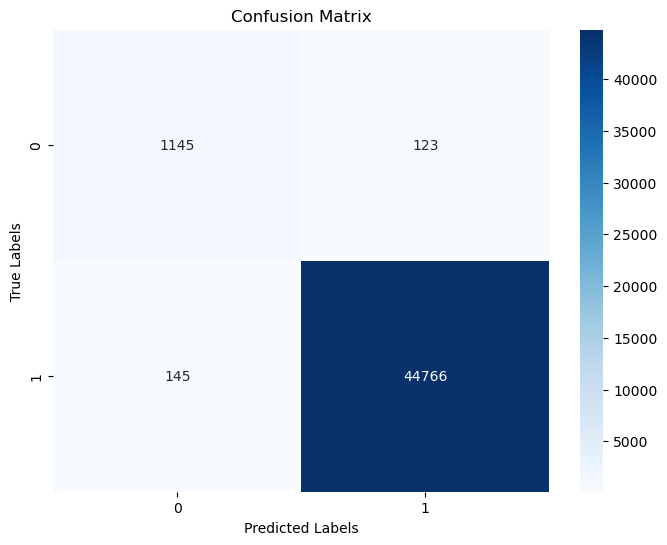

Confusion Matrix:
[[ 1145   123]
 [  145 44766]]


In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the best estimator from grid search
best_rf_model = rf_grid_search.best_estimator_

# Step 2: Make predictions using the test data (or validation set)
y_pred = best_rf_model.predict(X_test)  # Assuming X_test and y_test are your test set

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(cm)


## XGBoost

### Code Explanation
This code snippet is responsible for:
- **Preview:** `from xgboost import XGBClassifier

# Check XGBoost version`
- **Details:** Verifying that xgboost is installed properly


In [45]:
%pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# Check XGBoost version

print("XGBoost version:", xgb.__version__)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
XGBoost version: 2.1.2


### Code Explanation
This code snippet is responsible for:
- **Preview:** `print(X_train_resampled.info())
print(X_train_resampled.head())`
- **Details:** Add specific details about what this code achieves.


In [46]:
print(X_train_resampled.dtypes)


print(X_train_resampled.isnull().sum())  # Check for missing values
print(np.isinf(X_train_resampled).sum())  # Check for infinite values




score                      int64
session_frequency        float64
days_since_first         float64
days_between_sessions    float64
activity_intensity       float64
total_sessions           float64
score_density            float64
std_score                float64
avg_score_per_session    float64
last_session_score       float64
last_score_ratio         float64
dtype: object
score                    0
session_frequency        0
days_since_first         0
days_between_sessions    0
activity_intensity       0
total_sessions           0
score_density            0
std_score                0
avg_score_per_session    0
last_session_score       0
last_score_ratio         0
dtype: int64
score                    0
session_frequency        0
days_since_first         0
days_between_sessions    0
activity_intensity       0
total_sessions           0
score_density            0
std_score                0
avg_score_per_session    0
last_session_score       0
last_score_ratio         0
dtype: int64


### Code Explanation
This code snippet is responsible for:
- **Preview:** `from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV`
- **Details:**  Grid search is performed and the model is fitted using the optimal hyperparameters


In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost: Define parameter grid
# xgb_params = {
#     "n_estimators": [100, 200, 300],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "max_depth": [2, 3, 4, 6],
    # "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0]
# }

xgb_params = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [4]
}

# XGBoost: Initialize model and grid search
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Fit XGBoost with grid search
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and accuracy for XGBoost
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_
print("XGBoost Best Parameters:", xgb_best_params)
print("XGBoost Best CV Accuracy:", xgb_best_score)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\u679594\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
XGBoost Best CV Accuracy: 0.9402822813199208


### Code Explanation
This code snippet is responsible for:
- **Preview:** `from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns`
- **Details:** plotting the confusion matrix and presenting evaluation metrics


Accuracy: 0.9773

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1268
           1       1.00      0.98      0.99     44911

    accuracy                           0.98     46179
   macro avg       0.78      0.91      0.83     46179
weighted avg       0.98      0.98      0.98     46179



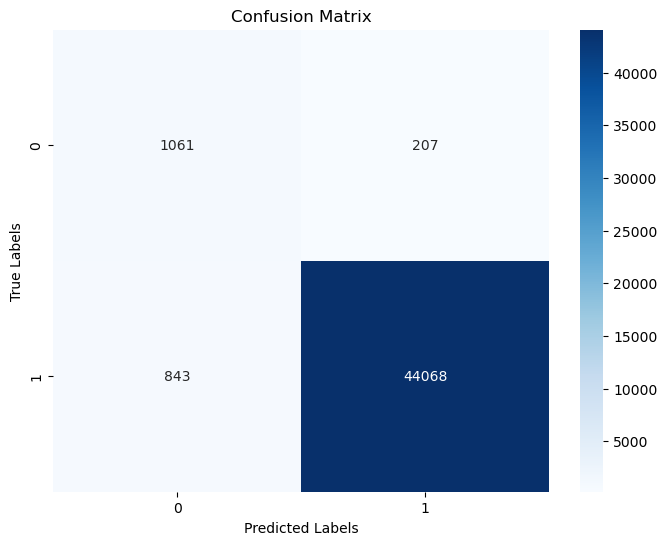

In [48]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the best estimator from grid search
best_xgb_model = xgb_grid_search.best_estimator_

# Step 2: Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print precision, recall, and F1 statistics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_xgb_model.classes_, yticklabels=best_xgb_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### LightGBM

##### Fitting the model and plotting the results

In [50]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for LightGBM
lgb_params = {
    'n_estimators': [100, 200],  # Number of trees
    'learning_rate': [0.05, 0.1],  # Learning rate
    'max_depth': [4, 6]  # Maximum depth of trees
}

# Initialize the LightGBM model
lgb_model = LGBMClassifier(random_state=42)

# Set up GridSearchCV for LightGBM
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_params,
    cv=5,
    scoring="accuracy",  # Metric for evaluation
    verbose=1,
    n_jobs=-1
)

# Fit LightGBM with grid search
lgb_grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and accuracy for LightGBM
lgb_best_params = lgb_grid_search.best_params_
lgb_best_score = lgb_grid_search.best_score_
print("LightGBM Best Parameters:", lgb_best_params)
print("LightGBM Best CV Accuracy:", lgb_best_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 104793, number of negative: 104793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2672
[LightGBM] [Info] Number of data points in the train set: 209586, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
LightGBM Best CV Accuracy: 0.9708520787337738


Test Accuracy: 0.9935

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1268
           1       1.00      1.00      1.00     44911

    accuracy                           0.99     46179
   macro avg       0.95      0.93      0.94     46179
weighted avg       0.99      0.99      0.99     46179



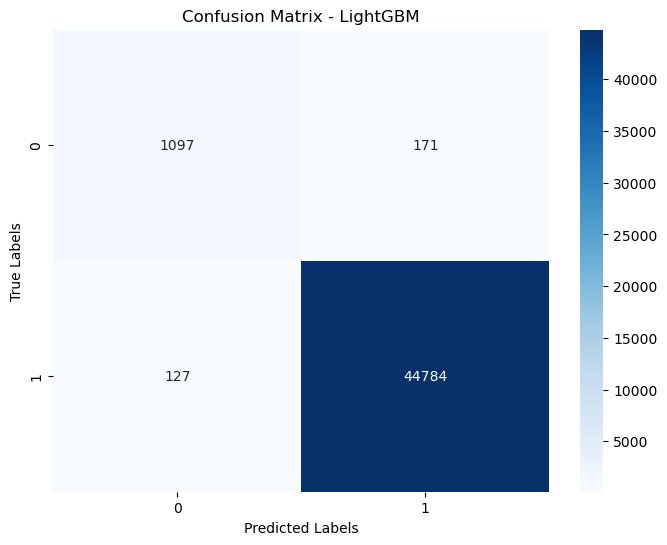

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the best estimator from grid search
best_lgb_model = lgb_grid_search.best_estimator_

# Step 2: Make predictions on the test set
y_pred = best_lgb_model.predict(X_test)  # Replace with your test feature dataset

# Step 3: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)  # Replace with your test target dataset
print(f"Test Accuracy: {accuracy:.4f}")

# Step 4: Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 6: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_lgb_model.classes_, yticklabels=best_lgb_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LightGBM')
plt.show()
